In [1]:
import numpy as np
import matplotlib.pyplot as plt
import cv2

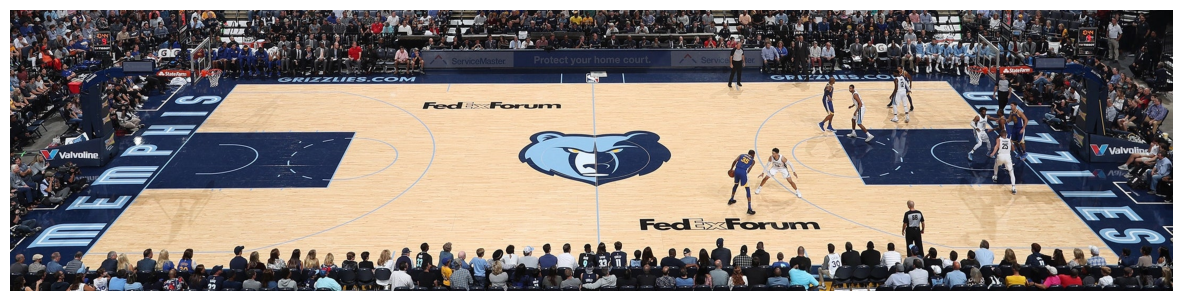

In [2]:
#Load the image
img = cv2.imread('./memphis.jpeg')
#Convert the image from BGR to RGB
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

#plot the image
plt.figure(figsize=(15, 15))
plt.imshow(img)
plt.axis('off')
plt.show()

# Feature extraction
In this section three ellipses are extracted from the image

In [16]:
def plot_points(points, color='r', label=None):
    """
    Plot points on the image.
    """
    plt.scatter(points[:, 0], points[:, 1], c=color, marker='x', label=label, s=10, linewidths=.5)

### Point selection (manual)

Please select points for Circle 1 and press Enter when done.
Selected points for Circle 1: [(np.float64(598.0181451612904), np.float64(245.7932358870969)), (np.float64(558.116935483871), np.float64(259.09363911290336)), (np.float64(525.6048387096774), np.float64(293.08355846774214)), (np.float64(553.6834677419355), np.float64(313.77307459677434)), (np.float64(595.0625), np.float64(318.2065423387098)), (np.float64(682.2540322580646), np.float64(312.2952520161292)), (np.float64(722.1552419354839), np.float64(287.1722681451614)), (np.float64(729.5443548387098), np.float64(267.96057459677434)), (np.float64(697.0322580645161), np.float64(247.27105846774214)), (np.float64(670.4314516129034), np.float64(242.83759072580665)), (np.float64(651.2197580645162), np.float64(241.3597681451614)), (np.float64(632.0080645161291), np.float64(241.3597681451614)), (np.float64(639.3971774193549), np.float64(319.68436491935495))]
Please select points for Circle 2 and press Enter when done.
Selected points fo

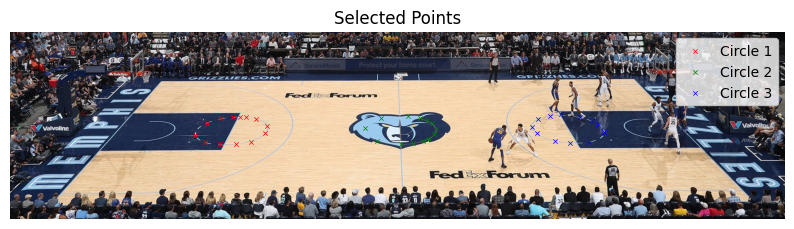

In [22]:
%matplotlib tk
# Display the image and allow the user to select points interactively
plt.figure(figsize=(10, 10))
plt.imshow(img)
plt.axis('off')
plt.title('Select points of the first circle')

def select_points(obj_name:str, color='r'):
    """
    Function to select points on the image.
    :param obj_name: Name of the object to select points for.
    :return: List of selected points.
    """
    plt.title(f'Select points for {obj_name}')
    print(f"Please select points for {obj_name} and press Enter when done.")
    points = plt.ginput(n=-1, timeout=0)  # n=-1 allows unlimited points, timeout=0 waits indefinitely
    print(f"Selected points for {obj_name}:", points)

    plot_points(np.array(points), color=color, label=obj_name)
    plt.legend()
    return points

# Use ginput to select points
points_C1 = select_points("Circle 1", color='r')
points_C2 = select_points("Circle 2", color='g')
points_C3 = select_points("Circle 3", color='b')

plt.close()

%matplotlib inline
plt.figure(figsize=(10, 10))
plt.imshow(img)
plt.axis('off')
plt.title('Selected Points')
plot_points(np.array(points_C1), color='r', label='Circle 1')
plot_points(np.array(points_C2), color='g', label='Circle 2')
plot_points(np.array(points_C3), color='b', label='Circle 3')
plt.legend()
plt.show()

#Save the points to a file
with open('selected_points.txt', 'w') as f:
    f.write("Circle 1:\n")
    for point in points_C1:
        f.write(f"{point[0]}, {point[1]}\n")
    f.write("\nCircle 2:\n")
    for point in points_C2:
        f.write(f"{point[0]}, {point[1]}\n")
    f.write("\nCircle 3:\n")
    for point in points_C3:
        f.write(f"{point[0]}, {point[1]}\n")

Loaded points for Circle 1: [[598.01814516 245.79323589]
 [558.11693548 259.09363911]
 [525.60483871 293.08355847]
 [553.68346774 313.7730746 ]
 [595.0625     318.20654234]
 [682.25403226 312.29525202]
 [722.15524194 287.17226815]
 [729.54435484 267.9605746 ]
 [697.03225806 247.27105847]
 [670.43145161 242.83759073]
 [651.21975806 241.35976815]
 [632.00806452 241.35976815]
 [639.39717742 319.68436492]]
Loaded points for Circle 2: [[1005.89717742  272.39404234]
 [1041.36491935  310.81742944]
 [1109.34475806  319.68436492]
 [1143.33467742  315.25089718]
 [1169.93548387  309.33960685]
 [1187.66935484  303.42831653]
 [1203.92540323  290.12791331]
 [1206.88104839  276.82751008]
 [1198.0141129   259.09363911]
 [1181.75806452  251.70452621]
 [1164.02419355  244.31541331]
 [1130.03427419  239.88194556]
 [1051.70967742  245.79323589]]
Loaded points for Circle 3: [[1480.27822581  269.43839718]
 [1493.57862903  288.65009073]
 [1545.30241935  310.81742944]
 [1588.15927419  315.25089718]
 [1642.838

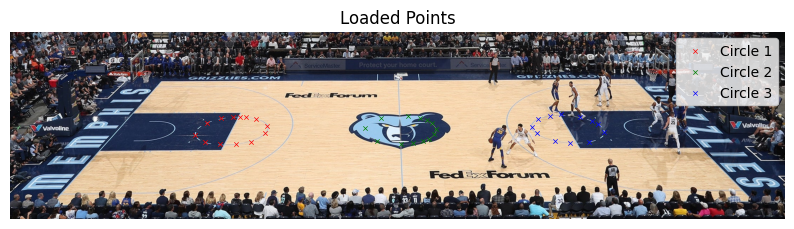

In [23]:
#Read points from the file
with open('selected_points.txt', 'r') as f:
    lines = f.readlines()
    points_C1 = []
    points_C2 = []
    points_C3 = []
    current_circle = None

    for line in lines:
        line = line.strip()
        if line.startswith("Circle 1:"):
            current_circle = points_C1
        elif line.startswith("Circle 2:"):
            current_circle = points_C2
        elif line.startswith("Circle 3:"):
            current_circle = points_C3
        elif line and current_circle is not None:
            x, y = map(float, line.split(','))
            current_circle.append((x, y))

    points_C1 = np.array(points_C1)
    points_C2 = np.array(points_C2)
    points_C3 = np.array(points_C3)

# Print the loaded points
print("Loaded points for Circle 1:", points_C1)
print("Loaded points for Circle 2:", points_C2)
print("Loaded points for Circle 3:", points_C3)

#Plot the loaded points
plt.figure(figsize=(10, 10))
plt.imshow(img)
plt.axis('off')
plt.title('Loaded Points')
plot_points(points_C1, color='r', label='Circle 1')
plot_points(points_C2, color='g', label='Circle 2')
plot_points(points_C3, color='b', label='Circle 3')
plt.legend()
plt.show()

### Fit Ellipse to points

In [54]:
from HomoTopiContinuation.DataStructures.datastructures import Conic, Conics, Homography

In [106]:
def getConic(x0, y0, MA, ma, theta):
    a = MA / 2
    b = ma / 2
    theta_rad = np.deg2rad(theta)
    c, s = np.cos(theta_rad), np.sin(theta_rad)

    A = (c**2) / (a**2) + (s**2) / (b**2)
    B = 2 * c * s * (1/(a**2) - 1/(b**2))
    C = (s**2) / (a**2) + (c**2) / (b**2)
    D = -2*A*x0 - B*y0
    E = -2*C*y0 - B*x0
    F = A*x0**2 + B*x0*y0 + C*y0**2 - 1
    matrix = np.array([[A, B/2, D/2], [B/2, C, E/2], [D/2, E/2, F]])
    matrix /= matrix[0, 0]  # Normalize the matrix
    return Conic(matrix)

In [107]:
# Fit ellipses to the points using OpenCV
ellipse_C1 = cv2.fitEllipse(points_C1.astype(np.float32))
ellipse_C2 = cv2.fitEllipse(points_C2.astype(np.float32))
ellipse_C3 = cv2.fitEllipse(points_C3.astype(np.float32))

print("Ellipse parameters for Circle 1:", ellipse_C1)
print("Ellipse parameters for Circle 2:", ellipse_C2)
print("Ellipse parameters for Circle 3:", ellipse_C3)

#Convert the ellipses to matrix form
C1 = getConic(*ellipse_C1[0], *ellipse_C1[1], ellipse_C1[2])
C2 = getConic(*ellipse_C2[0], *ellipse_C2[1], ellipse_C2[2])
C3 = getConic(*ellipse_C3[0], *ellipse_C3[1], ellipse_C3[2])

print("Conic matrix for Circle 1:\n", C1.M)
print("Conic matrix for Circle 2:\n", C2.M)
print("Conic matrix for Circle 3:\n", C3.M)

Ellipse parameters for Circle 1: ((628.6072998046875, 281.1561584472656), (78.1078872680664, 204.38092041015625), 85.42514038085938)
Ellipse parameters for Circle 2: ((1106.2872314453125, 279.0335388183594), (80.4345703125, 204.52587890625), 89.0827865600586)
Ellipse parameters for Circle 3: ((1581.6185302734375, 275.9638366699219), (79.00634765625, 203.40049743652344), 95.19007873535156)
Conic matrix for Circle 1:
 [[ 1.00000000e+00  4.48196506e-01 -7.54620508e+02]
 [ 4.48196506e-01  6.56543919e+00 -2.12765326e+03]
 [-7.54620508e+02 -2.12765326e+03  1.06249440e+06]]
Conic matrix for Circle 2:
 [[ 1.00000000e+00  8.73587096e-02 -1.13066324e+03]
 [ 8.73587096e-02  6.45519152e+00 -1.89785876e+03]
 [-1.13066324e+03 -1.89785876e+03  1.76996147e+06]]
Conic matrix for Circle 3:
 [[ 1.00000000e+00 -4.84696811e-01 -1.44785974e+03]
 [-4.84696811e-01  6.29213209e+00 -9.69795456e+02]
 [-1.44785974e+03 -9.69795456e+02  2.54770269e+06]]


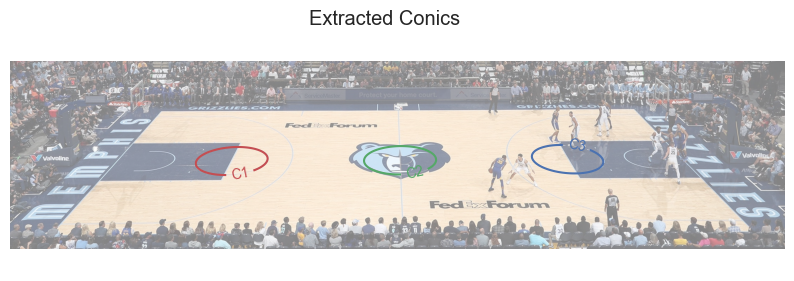

In [108]:
from HomoTopiContinuation.Plotter.Plotter import Plotter
plotter = Plotter(1, 1, title = "Extracted Conics", figsize=(10, 3))
plotter.newAxis(axisSame=False)
plotter.getCurrentAxis().imshow(img, alpha=0.5)
plotter.getCurrentAxis().axis('off')
plotter.getCurrentAxis().grid(False)
plotter.plotConic2D(C1, color='r', conicName="C1")
plotter.plotConic2D(C2, color='g', conicName="C2")
plotter.plotConic2D(C3, color='b', conicName="C3")
plotter.show()

# Rectification

In [109]:
from HomoTopiContinuation.Rectifier.homotopyc_rectifier import HomotopyContinuationRectifier
from HomoTopiContinuation.Rectifier.numeric_rectifier import NumericRectifier

rectifier = HomotopyContinuationRectifier()
H = rectifier.rectify(Conics(C1, C2, C3))
print(H.H)

[[-7.07106369e-01 -5.45123476e-04  0.00000000e+00]
 [-2.81902506e-03  3.65669553e+00  0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00  1.00000000e+00]]


In [110]:
#Rotate the homography by 90 deg counter clockwise
H.H = np.array([[0, 1, 0],
              [-1, 0, 0],
              [0, 0, 1]]) @ H.H

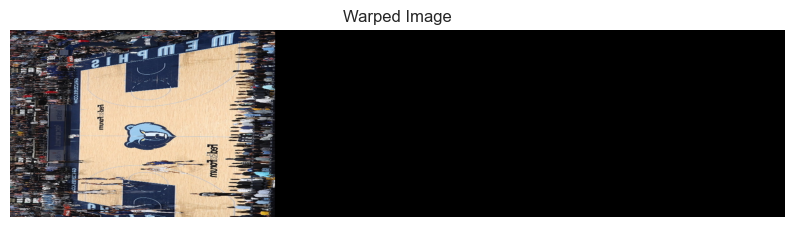

In [111]:
from HomoTopiContinuation.ImageWarper.ImageWarper import ImageWarper
warper = ImageWarper()
warped_img = ImageWarper()(img, Homography(H.inv()))
plt.figure(figsize=(10, 10))
plt.imshow(warped_img)
plt.axis('off')
plt.title('Warped Image')
plt.show()